## Task 0: Theory Questions
### Q1: Why is the KL Divergence term important in the VAE loss function?
The KL Divergence term serves as a regularization term in the VAE loss function. More specifically, it helps to prevent overfitting, ensures completness, and allows to generate new images effectively. To help prevent overfitting, the KL term forces to encode the latent variables in Gaussian distribution to avoid having a sparse latent space. The KL term also forces points that are close in the latent space to result in similar outputs thus ensuring that anything sampled from the latent space can result in a meningful output. Finally, since the KL term forces the latent space into Gaussian distribution, we can sample anything from it to get a never before seen image. 

### Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
The reparametrization trick "concentrates" randomness in the stochastic layer by introducing modifications to $\epsilon$. Without trick, the sample is taken from normal distribution which makes the backward propogation trying to taken a derivative of a random node which is not possible. Thus, the reparametrization trick allows for a differentiable path so that the model can "see" how changing the encoder's weights affects the final reconstructed image.

### Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
Fixed laten spaces consist of a whole nunmch of discrete points. When clustered, there tends to be a lot of separation between the clusters which makes it difficult for the model to generate a new image since it can classify it as 'never seen before'. The probabilistic latent space forces continuity and overlap between the clusters thus making it easier for the model to generate new images. 

### Q4: What role does KL Divergence play in ensuring a smooth latent space?
The KL divergence forces the model to "organize" the latent space instead of simply reconstructing it. Simple reconstruction leads to "overfitting" the coordinates, where each image is hidden in its own private corner of the space.The KL term also forces the overlap discussed above which is crucial for the probabilistic latent space. 


## Task 1: Modifyt VAE architecture
Modify the VAE architecture to use convolutional layers for both the encoder and decoder, and
train it on the CIFAR-10 dataset. This modification will allow the model to capture spatial relationships
within images more effectively, improving its ability to generate high-quality images. After training, compare
the generated images with those from a fully connected VAE.

In [8]:
#############################################################################
# alternatively, use tensorflow so scalability
##########################################################################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torchvision.utils import make_grid, save_image
import numpy as np
import warnings
import matplotlib.pyplot as plt
#Note: requires install of numpy <2.0 because of dataset loading

### Task 1.1: Define classes for FCVAE and CVAE

In [3]:
#standard fully connected VAE
class FC_VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(FC_VAE, self).__init__()
        # Flattened input: 32*32*3 = 3072
        self.encoder_net = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        self.decoder_net = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3072),
            nn.Sigmoid() 
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Flatten: (Batch, 3, 32, 32) -> (Batch, 3072)
        x = x.view(-1, 3072)
        h = self.encoder_net(x)
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        # Decode and reshape back to image dimensions
        recon = self.decoder_net(z).view(-1, 3, 32, 32)
        return recon, mu, logvar


#modified VAE
class CVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(CVAE, self).__init__()
        
        # Encoder: (3, 32, 32) -> (128, 4, 4)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 4x4
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        
        # Decoder: Latent -> (3, 32, 32)
        self.decoder_input = nn.Linear(latent_dim, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 32x32
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        
        z = self.decoder_input(z).view(-1, 128, 4, 4)
        return self.decoder(z), mu, logvar

### Task 1.2: Define hyper parameters

In [50]:
#parameter sets to explore
from types import SimpleNamespace
import torch

#"Default" Parameter Set 1
p1 = SimpleNamespace(
    param_set="p1",  # parameter set label
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    batch_size=64,
    learning_rate=1e-3,
    epochs=100,
    latent_dim=128,
    patience=5,          # Number of epochs to wait for improvement
    min_delta=0.5,       # Minimum change in loss to qualify as an improvement
    best_loss=float('inf'),
    counter=0
)

#Note: Learning rate of 1e-3 can be unstable so it was changed for the next two parameter sets
#Parameter Set 2 - Increase batch size and decrease learning rate
p2 = SimpleNamespace(
    param_set="p2",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    batch_size=128,
    learning_rate=5e-4,
    epochs=100,
    latent_dim=128,
    patience=5,          # Number of epochs to wait for improvement
    min_delta=0.5,       # Minimum change in loss to qualify as an improvement
    best_loss=float('inf'),
    counter=0
)

#Parameter Set 3 - Increase latent dimension and decrease learning rate
p3 = SimpleNamespace(
    param_set = "p3",
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    batch_size=64,
    learning_rate=5e-4,
    epochs=100,
    latent_dim=256,
    patience=5,
    min_delta=0.5,
    best_loss=float('inf'),
    counter=0
)

### Task 1.3: Train FCVAE

In [51]:
# Suppress the legacy pickle warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
#unpack parameters
params = p3
device = params.device
batch_size = params.batch_size
learning_rate = params.learning_rate
epochs = params.epochs
latent_dim = params.latent_dim
patience = params.patience
min_delta = params.min_delta
best_loss = params.best_loss
counter = params.counter

#create modelName
modelName = f"best_fcvae_cifar10_{params.param_set}.pth"

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = FC_VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
    # Flatten both to compare pixel by pixel
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# --- 3. Training Loop ---
print("Starting Fully Connected VAE Training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        
        recon, mu, logvar = model(images)
        loss = loss_function(recon, images, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

        # --- Early Stopping Logic ---
    if avg_loss < (best_loss - min_delta):
        best_loss = avg_loss
        counter = 0
        # Save the best model state
        torch.save(model.state_dict(), modelName)
        print(f"  --> Improvement found. Saving model...")
    else:
        counter += 1
        print(f"  --> No significant improvement. Plateau count: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered at Epoch {epoch+1}. Model has plateaued.")
            break

Starting Fully Connected VAE Training...
Epoch 1, Loss: 140.1990
  --> Improvement found. Saving model...
Epoch 2, Loss: 121.5890
  --> Improvement found. Saving model...
Epoch 3, Loss: 111.1077
  --> Improvement found. Saving model...
Epoch 4, Loss: 102.1424
  --> Improvement found. Saving model...
Epoch 5, Loss: 95.4107
  --> Improvement found. Saving model...
Epoch 6, Loss: 94.1367
  --> Improvement found. Saving model...
Epoch 7, Loss: 92.2332
  --> Improvement found. Saving model...
Epoch 8, Loss: 91.1003
  --> Improvement found. Saving model...
Epoch 9, Loss: 89.5860
  --> Improvement found. Saving model...
Epoch 10, Loss: 88.1561
  --> Improvement found. Saving model...
Epoch 11, Loss: 87.7735
  --> No significant improvement. Plateau count: 1/5
Epoch 12, Loss: 87.4801
  --> Improvement found. Saving model...
Epoch 13, Loss: 86.8652
  --> Improvement found. Saving model...
Epoch 14, Loss: 85.6328
  --> Improvement found. Saving model...
Epoch 15, Loss: 84.9446
  --> Improvement 

KeyboardInterrupt: 

### Task 1.4: Train CVAE

In [52]:
# Suppress the legacy pickle warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
params = p3
device = params.device
batch_size = params.batch_size
learning_rate = params.learning_rate
epochs = params.epochs
latent_dim = params.latent_dim
patience = params.patience
min_delta = params.min_delta
best_loss = params.best_loss
counter = params.counter

#create modelName
modelName = f"best_cvae_cifar10_{params.param_set}.pth"

# Data Loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = CVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

# Training Loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}, Average Loss: {avg_loss:.4f}')

    # --- Early Stopping Logic ---
    if avg_loss < (best_loss - min_delta):
        best_loss = avg_loss
        counter = 0
        # Save the best model state
        torch.save(model.state_dict(), modelName)
        print(f"  --> Improvement found. Saving model...")
    else:
        counter += 1
        print(f"  --> No significant improvement. Plateau count: {counter}/{patience}")
        if counter >= patience:
            print(f"Early stopping triggered at Epoch {epoch+1}. Model has plateaued.")
            break

Epoch 1, Average Loss: 115.4024
  --> Improvement found. Saving model...
Epoch 2, Average Loss: 87.4709
  --> Improvement found. Saving model...
Epoch 3, Average Loss: 81.8653
  --> Improvement found. Saving model...
Epoch 4, Average Loss: 79.7371
  --> Improvement found. Saving model...
Epoch 5, Average Loss: 78.4771
  --> Improvement found. Saving model...
Epoch 6, Average Loss: 77.5643
  --> Improvement found. Saving model...
Epoch 7, Average Loss: 77.0514
  --> Improvement found. Saving model...
Epoch 8, Average Loss: 76.7547
  --> No significant improvement. Plateau count: 1/5
Epoch 9, Average Loss: 76.4423
  --> Improvement found. Saving model...
Epoch 10, Average Loss: 76.2012
  --> No significant improvement. Plateau count: 1/5
Epoch 11, Average Loss: 76.0360
  --> No significant improvement. Plateau count: 2/5
Epoch 12, Average Loss: 75.8315
  --> Improvement found. Saving model...
Epoch 13, Average Loss: 75.7301
  --> No significant improvement. Plateau count: 1/5
Epoch 14, A

KeyboardInterrupt: 

### Task 1.5: Generate images for comparisson

Comparison complete! Saved:
generated_images_Convolutional_VAE_p3.png
generated_images_FullyConnected_VAE_p3.png


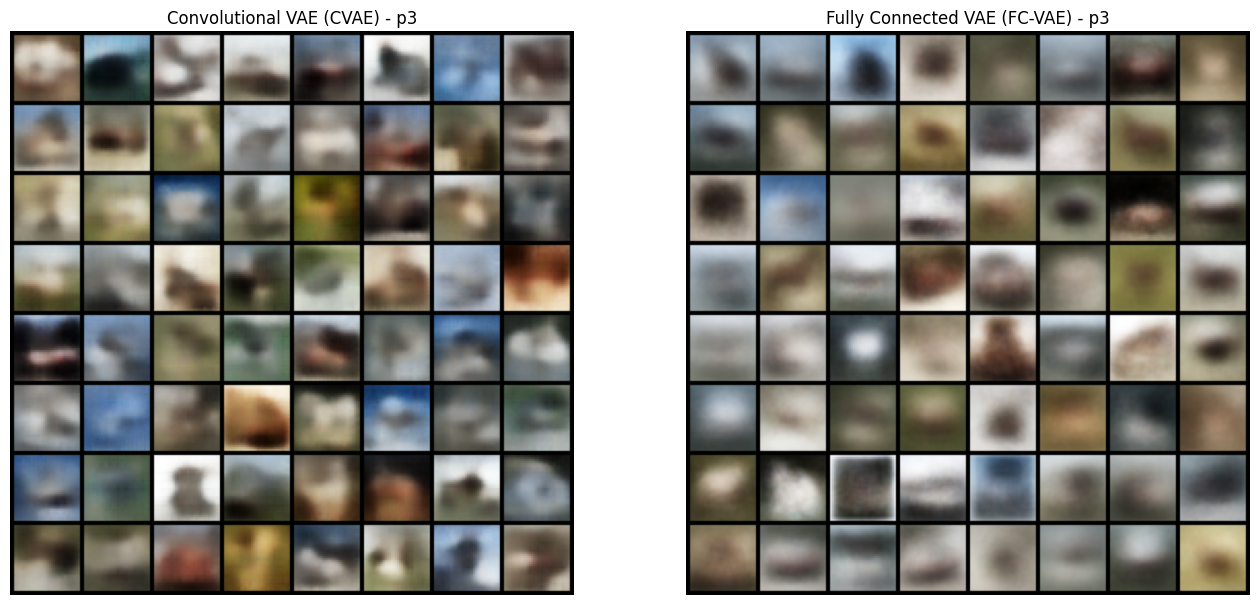

In [53]:
# --- 1. Load the Models ---
params = p3
device = params.device
latent_dim = params.latent_dim


modelFC = f"best_fcvae_cifar10_{params.param_set}.pth"
modelCV = f"best_cvae_cifar10_{params.param_set}.pth"

# Initialize Models
conv_model = CVAE(latent_dim=latent_dim).to(device)
fc_model = FC_VAE(latent_dim=latent_dim).to(device)

# Load Saved Weights
conv_model.load_state_dict(torch.load(modelCV, map_location=device))
fc_model.load_state_dict(torch.load(modelFC, map_location=device))

conv_model.eval()
fc_model.eval()

# --- 2. Generate Images ---
num_samples = 64 # Create an 8x8 grid
with torch.no_grad():
    # Use the same noise for both models to see how they interpret the same "idea"
    z = torch.randn(num_samples, latent_dim).to(device)
    
    # Generate from Convolutional VAE
    # We pass z through the decoder part of your CVAE
    c_input = conv_model.decoder_input(z).view(-1, 128, 4, 4)
    c_gen = conv_model.decoder(c_input)
    
    # Generate from Fully Connected VAE
    # FC_VAE reshapes inside its decoder_net or forward; we use the decoder_net directly
    f_gen = fc_model.decoder_net(z).view(-1, 3, 32, 32)

# --- 3. Save the Grids ---

save_image(c_gen, f"generated_images_Convolutional_VAE_{params.param_set}.png", nrow=8, normalize=True)
save_image(f_gen, f"generated_images_FullyConnected_VAE_{params.param_set}.png", nrow=8, normalize=True)

print("Comparison complete! Saved:")
print(f"generated_images_Convolutional_VAE_{params.param_set}.png")
print(f"generated_images_FullyConnected_VAE_{params.param_set}.png")

# --- Notebook Display ---
grid_c = make_grid(c_gen, nrow=8, normalize=True).cpu().permute(1, 2, 0)
grid_f = make_grid(f_gen, nrow=8, normalize=True).cpu().permute(1, 2, 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(grid_c)
ax[0].set_title(f"Convolutional VAE (CVAE) - {params.param_set}")
ax[0].axis('off')

ax[1].imshow(grid_f)
ax[1].set_title(f"Fully Connected VAE (FC-VAE) - {params.param_set}")
ax[1].axis('off')

plt.show()

### Task 1.6: Discussion of results and notes on Training

The training stops based on plateuing loss function to keep the training time reasonable and save the best possible model for further evaluations.
I did a few training rounds in an attempt to improve generated images. The parameter sets are available in code format below the table. More images can be generated using code in Task 1.5

| Parameter Set | CVAE Epochs | FCVAE Epochs | CVAE Average Loss | FCVAE Average Loss | CVAE Image | FCVAE Image |
|:-------------:|:-----------:|:------------:|:-----------------:|:------------------:|:----------:|:-----------:|
| 1             | 18          | 40           | 74.7              | 80.7               | ![](generated_images_Convolutional_VAE_p1.png) | ![](generated_images_FullyConnected_VAE_p1.png) |
| 2             | 21          | 33           | 74.9              | 78.2               | ![](generated_images_Convolutional_VAE_p2.png) | ![](generated_images_FullyConnected_VAE_p2.png) |
| 3             | 15          | 23           | 75.4              | 82.6               | ![](generated_images_Convolutional_VAE_p3.png) | ![](generated_images_FullyConnected_VAE_p3.png) |

For parameter set 2, FCVAE training was manually interrupted since it was plautauing every 3 steps without reaching the critical 5 step plateau. Despite the interruption, parameter set 2 training resulted in smaller average loss with fewer epochs necessary. CVAE performed slightly worse than in parameter set 1 and required a few more epochs to plateau. The images produced are a lot more vivid for both with some more concrete shapes showing up.

For parameter set 3, similar behaviour occured as for parameter set 2. Interestingly enough, the images generated by CVAE model look very similar across the different parameter sets.

Based on experimentation, the FCVAE model starts out with a highger loss average and the epochs start plateuing faster. 
In order to improve the resulting images, we can try to increase batch size, decrease learning rate, and increase the latent dimensions. All of those modifications and their combinations should result in more fine-grained images.

## Task 2: Images in Latent Space
Using the trained VAE, interpolate between two images in the latent space and generate intermediate
images. This demonstrates how smoothly the model can transition between different data points. Visualize
and display the results, showing the interpolated images in a grid format to observe the transformation.


The images were generated using convolutional model with parameter set 1. Based on the images generated, it seems like the algorithm is slowly changing the shape and then adding in the colours. Over the 10 images shown belowm it seems like the algorithm focus on one without changing the other much at each step.

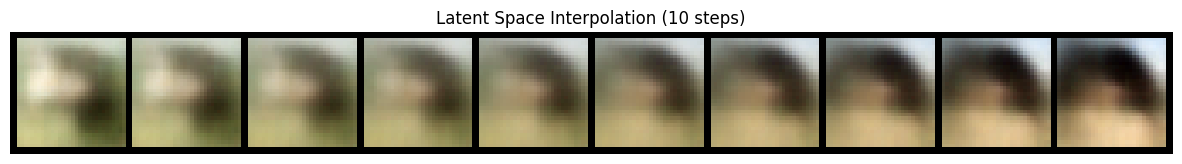

<Figure size 640x480 with 0 Axes>

In [54]:
# --- 1. Load the Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 128
modelCV = 'best_cvae_cifar10.pth'

conv_model = CVAE(latent_dim=latent_dim).to(device)
conv_model.load_state_dict(torch.load(modelCV, map_location=device))
conv_model.eval()

# --- 2. Latent Space Interpolation ---
num_steps = 10  # Number of intermediate images
with torch.no_grad():
    # Start and End points in latent space
    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)
    
    # Create interpolation weights (from 0 to 1)
    alphas = torch.linspace(0, 1, steps=num_steps).to(device)
    
    # Interpolate: z_interp = (1 - alpha) * z1 + alpha * z2
    # We use unsqueeze/broadcasting to handle the batch math
    z_interp = (1 - alphas).unsqueeze(1) * z1 + alphas.unsqueeze(1) * z2
    
    # Pass through the decoder
    # Note: Use the same architecture logic from your previous snippet
    c_input = conv_model.decoder_input(z_interp).view(-1, 128, 4, 4)
    interpolated_images = conv_model.decoder(c_input)

# --- 3. Visualization ---
grid = make_grid(interpolated_images, nrow=num_steps, normalize=True).cpu().permute(1, 2, 0)

plt.figure(figsize=(15, 5))
plt.imshow(grid)
plt.title(f"Latent Space Interpolation ({num_steps} steps)")
plt.axis('off')
plt.show()
plt.show()

## Task 3: New Dataset
Train the VAE on a new dataset of your choice (e.g., CelebA for faces), and visualize generated
samples. Experiment with sampling from different regions of the latent space and analyze how the generated
outputs vary based on different latent vectors.
Note: I only included 30% of the whole dataset since it was too large to work on my CPU. Since I used a smaller subset, the images turned out pretty blurry towards the end. Varrying parameters and/or including more data can lead to better results. 

In [ ]:
#needs to be manually downloaded before passed on for training
transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),
])

# manual download
train_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [35]:
# --- Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
learning_rate = 1e-3
epochs = 100  
latent_dim = 128
patience = 5
min_delta = 0.5

# --- Data Preparation ---
print("Configuring Data Loader...")
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Load the full dataset
full_train_dataset = datasets.CelebA(root='./data', split='train', download=True, transform=transform)

# Calculate indices for 30% subset
subset_size = int(0.3 * len(full_train_dataset))
indices = np.random.choice(len(full_train_dataset), subset_size, replace=False)
train_dataset = Subset(full_train_dataset, indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print(f"Dataset subset created: Using {len(train_dataset)} images (30% of total).")

Configuring Data Loader...
Dataset subset created: Using 48831 images (30% of total).


In [36]:
print(f"--- Initializing CVAE Training on {device} ---")
model = CVAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_loss = float('inf')
counter = 0

print("Starting training loop...")
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        # Batch progress print (every 500 batches)
        if batch_idx % 500 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
        
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Complete | Average Loss: {avg_loss:.4f}')

    # Early Stopping Logic
    if avg_loss < (best_loss - min_delta):
        print(f"Improvement detected! Loss decreased from {best_loss:.4f} to {avg_loss:.4f}. Saving model...")
        best_loss = avg_loss
        counter = 0
        torch.save(model.state_dict(), 'best_cvae_celebsA.pth')
    else:
        counter += 1
        print(f'No significant improvement. Early Stopping Counter: {counter}/{patience}')
        
    if counter >= patience:
        print("!!! Early stopping triggered. Training stopped early. !!!")
        break

print("--- Training Process Finished ---")

--- Initializing CVAE Training on cpu ---
Starting training loop...
Train Epoch: 1 [0/48831 (0%)]	Loss: 291.833893
Train Epoch: 1 [32000/48831 (66%)]	Loss: 86.268578
====> Epoch: 1 Complete | Average Loss: 106.8589
Improvement detected! Loss decreased from inf to 106.8589. Saving model...
Train Epoch: 2 [0/48831 (0%)]	Loss: 78.850708
Train Epoch: 2 [32000/48831 (66%)]	Loss: 71.724770
====> Epoch: 2 Complete | Average Loss: 75.6569
Improvement detected! Loss decreased from 106.8589 to 75.6569. Saving model...
Train Epoch: 3 [0/48831 (0%)]	Loss: 70.240662
Train Epoch: 3 [32000/48831 (66%)]	Loss: 70.658813
====> Epoch: 3 Complete | Average Loss: 72.8404
Improvement detected! Loss decreased from 75.6569 to 72.8404. Saving model...
Train Epoch: 4 [0/48831 (0%)]	Loss: 72.430115
Train Epoch: 4 [32000/48831 (66%)]	Loss: 71.894516
====> Epoch: 4 Complete | Average Loss: 71.5736
Improvement detected! Loss decreased from 72.8404 to 71.5736. Saving model...
Train Epoch: 5 [0/48831 (0%)]	Loss: 71.8

The model generated the images shown below. Even though they are blurry, it does seem like a human face. If we use more training data or different parameters, the results may improve. 

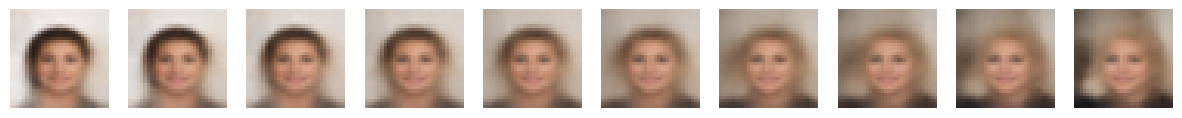

In [37]:
def interpolate(model, z1, z2, steps=10):
    model.eval()
    with torch.no_grad():
        # Linear interpolation between z1 and z2
        alpha = torch.linspace(0, 1, steps).to(device)
        # Reshape for broadcasting: (steps, 1)
        alpha = alpha.view(-1, 1)
        z = (1 - alpha) * z1 + alpha * z2
        
        # Decode the interpolated vectors
        samples = model.decoder_input(z).view(-1, 128, 4, 4)
        samples = model.decoder(samples).cpu()
        return samples

# Sample two random latent vectors
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)

interpolated_images = interpolate(model, z1, z2)

# Plotting the transition
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(interpolated_images[i].permute(1, 2, 0))
    axes[i].axis('off')
plt.show()


Generative AI Use Disclaimer: some of the code in this project was generated using AI. All of the outputs were reviewed before including them into the project.